In [1]:
import librosa

In [ ]:
!pip install matplotlib

In [2]:
import matplotlib.pyplot
import os
import pandas as pd
import numpy as np

In [ ]:
main_path="C:\\Users\\adity\\Desktop\\Capstone\\data"

In [ ]:
data_files = list(os.listdir(main_path))

In [ ]:
metadata = {"file_path":[],"category":[]}

count=-1
cats = ['irish_english_male', 'midlands_english_female', 'midlands_english_male', 
        'northern_english_female', 'northern_english_male', 'scottish_english_female', 'scottish_english_male', 
        'southern_english_female', 'southern_english_male', 'welsh_english_female', 'welsh_english_male']
for dirname, dirnames, filenames in os.walk(main_path):
    # print path to all filenames.
    file_paths=[]
    for filename in filenames:
        path= os.path.join(dirname, filename)
        path = os.path.normpath(path)
        file_paths.append(path.replace("\\","/"))
    metadata['file_path']=metadata['file_path']+file_paths
    metadata['category']=metadata['category']+([cats[count]]*len(file_paths))
    count+=1

In [ ]:
df = pd.DataFrame(metadata)

In [ ]:
df.columns=['file_path','class_label']

In [ ]:
df.to_csv("data_metadata.csv",index=False)

In [3]:
data = pd.read_csv("data_metadata.csv")

In [4]:
import tensorflow as tf
from keras.utils import to_categorical

In [5]:
class AudioDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, csv_file, batch_size=32, num_classes=11, sample_rate=22050, duration=10.0, shuffle=True, n_mels=128):
        self.csv_file = csv_file
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.sample_rate = sample_rate
        self.duration = duration
        self.shuffle = shuffle
        self.n_mels  = n_mels
        
        # Read the CSV file
        self.data = pd.read_csv(csv_file)
        
        # Get the unique class labels
        self.classes = sorted(self.data['class_label'].unique())
        
        # Create a dictionary to map class labels to integers
        self.class_to_int = dict(zip(self.classes, range(len(self.classes))))
        
        # Shuffle the data if requested
        if self.shuffle:
            self.data = self.data.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        # Return the number of batches
        return int(np.ceil(len(self.data) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        # Get the batch of file paths and labels
        batch_data = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_data = batch_data.reset_index()
        
        # Initialize the arrays for the audio data and labels
        batch_x = np.zeros((len(batch_data), self.n_mels, 431,1))
        batch_y = np.zeros((len(batch_data), self.num_classes))
        
        # Load the audio files and their corresponding labels
        for i, row in batch_data.iterrows():
            file_path = row['file_path']
            class_label = row['class_label']
            
            # Load the audio file
            signal, sr = librosa.load(file_path, sr=self.sample_rate, mono=True)
            
            # Pad or truncate the signal to the desired length
            signal = librosa.util.fix_length(signal, size=self.sample_rate * self.duration)
            
            # Convert the audio file to spectrogram
            S = librosa.feature.melspectrogram(y=signal, sr=sr)
            S_dB = np.array(librosa.power_to_db(S, ref=np.max))
            S_dB = S_dB.reshape(S_dB.shape[0],S_dB.shape[1],1)
            
            # Save the audio data and label to the batch arrays
            batch_x[i, :] = S_dB
            batch_y[i, :] = to_categorical(self.class_to_int[class_label], num_classes=self.num_classes)
            
#         batch_x.reshape(self.batch_size,batch_x.shape[0],batch_x.shape[1])
        return batch_x, batch_y

In [ ]:
def split_data(data):
    data = data.sample(frac=1,axis=0,ignore_index=True)
    train = data[0:int(len(data)*0.8)]
    test = data[int(len(data)*0.8):]
    return train,test

In [ ]:
train_data,val_data = split_data(data)

In [ ]:
train_data

In [ ]:
train_data.to_csv('train_data.csv',index=False)
val_data.to_csv('val_data.csv',index=False)

In [6]:
train_data = pd.read_csv("train_data.csv")
val_data = pd.read_csv("val_data.csv")

In [7]:
train_generator = AudioDataGenerator('train_data.csv', batch_size=32, num_classes=11, sample_rate=22050, duration=10, shuffle=True, n_mels=128)

In [8]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [11]:
#Model 2
model = Sequential()

model.add(Conv2D(32,(3,3),input_shape=(128,431,1),activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(11,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',f1_m,precision_m, recall_m])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 431, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 215, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 215, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 107, 64)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 107, 128)      73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 53, 128)      0

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

In [13]:
history = model.fit(train_generator,batch_size=32,epochs=16,verbose=1)

Epoch 1/10
447/447 [==============================] - 395s 862ms/step - loss: 2.8996 - accuracy: 0.4276 - f1_m: 0.2657 - precision_m: 0.4506 - recall_m: 0.1975
Epoch 2/10
447/447 [==============================] - 380s 851ms/step - loss: 1.2055 - accuracy: 0.5535 - f1_m: 0.4706 - precision_m: 0.6862 - recall_m: 0.3692
Epoch 3/10
447/447 [==============================] - 370s 827ms/step - loss: 1.0199 - accuracy: 0.6126 - f1_m: 0.5668 - precision_m: 0.7251 - recall_m: 0.4708
Epoch 4/10
447/447 [==============================] - 365s 817ms/step - loss: 0.7564 - accuracy: 0.7109 - f1_m: 0.6926 - precision_m: 0.7750 - recall_m: 0.6292
Epoch 5/10
447/447 [==============================] - 361s 808ms/step - loss: 0.5440 - accuracy: 0.7912 - f1_m: 0.7866 - precision_m: 0.8293 - recall_m: 0.7493
Epoch 6/10
447/447 [==============================] - 359s 802ms/step - loss: 0.4315 - accuracy: 0.8353 - f1_m: 0.8312 - precision_m: 0.8608 - recall_m: 0.8046
Epoch 7/10
447/447 [====================

In [14]:
val_generator = AudioDataGenerator('val_data.csv', batch_size=32, num_classes=11, sample_rate=22050, duration=10, shuffle=True, n_mels=128)

In [15]:
model.save("CNN_2.h5")

In [15]:
model =tf.keras.models.load_model("CNN.h5",custom_objects={"f1_m":f1_m,'precision_m':precision_m, 'recall_m':recall_m})

In [1]:
# Evaluate the model on the validation data
loss, accuracy, f1_score, precision, recall = model.evaluate(val_generator)


NameError: name 'model' is not defined

In [16]:
# Print the validation accuracy and loss
print('Validation accuracy:', accuracy)
print('Validation loss:', loss)
print('Validation f1:', f1_score)
print('Validation precision:', precision)
print('Validation recall:', recall)


Validation accuracy: 0.801174521446228
Validation loss: 0.7103021144866943
Validation f1: 0.8001530766487122
Validation precision: 0.8107374906539917
Validation recall: 0.7900856137275696


In [18]:
import pickle

In [19]:
pickle_out = open("CNN_history.pickle","wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

In [20]:
pickle_in = open('CNN_history.pickle', "rb")
history = pickle.load(pickle_in)

In [17]:
history = history.history

In [18]:
# from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

In [19]:
print(history.keys())

dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m'])


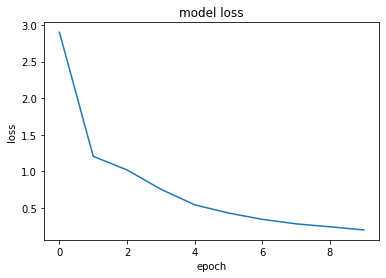

In [20]:
plt.plot(history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
plt.close()

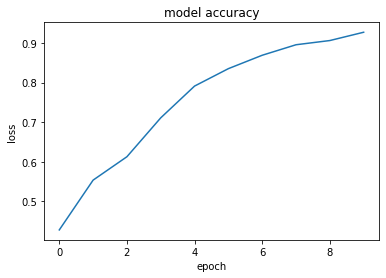

In [21]:
plt.plot(history['accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
plt.close()

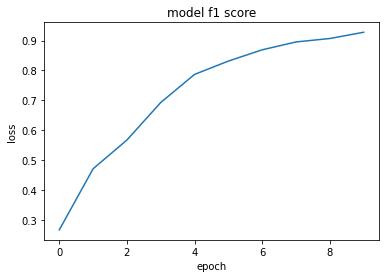

In [22]:
plt.plot(history['f1_m'])
plt.title('model f1 score')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
plt.close()

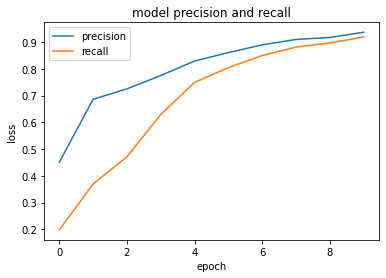

In [23]:
plt.plot(history['precision_m'])
plt.plot(history['recall_m'])
plt.title('model precision and recall')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['precision','recall'])
plt.show()
plt.close()